## Use scaling for longer canyon

Using scaling and fitted functions from notebook scalling_tracer_flux_paper1_clean.ipynb, see if our scaling works when using a longer canyon.

L = 12800.0 m, vs 6400.0 m from Barkley-like run

R = 5000.0 m

Wm = 24432.4 m, Width at shelf break

W = 22044.8 m, mid-length width at rim depth

Ws = 13756.1 m, mid-length width at shelf-break isobath

Hs = 150.0 m,  Shelf break depth

s = 0.005 m, shelf slope 

Hh = 97.5 m, head depth

Hr = 132.0 m, rim depth at DnS

No = 5.5E-3 s$^{-1}$, Initial stratification at shelf-break depth

f = 9.66E-5 s$^{-1}$, Coriois parameter 

U = 0.344 ms$^{-1}$,  incoming velocity base case, m/s (from model)



In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [35]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [36]:
sns.set_context('paper')
sns.set_style('white')

In [37]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/LONGER_CNY2/run01/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/LONGER_CNY2/run01/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']
RC = CanyonGridOut.variables['RC']

In [38]:
# Constants and scales

L = 9600 #12800#6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Hs = 149.8 # Shelf break depth
s = 0.005 # shelf slope
Wr = 13756.1 # mid-length width at shelf break isobath
W = 22044.8 # mid-length width at rim depth
Hh= 72.3 #98.8 # head depth
Hr = 89.1 # rim depth at UwH

N = 5.5E-3
f = 9.66E-5
U = 0.35
Co = 5.06

# NOTE: The default values of all functions correspond to the base case

def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N,f,Hs):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

In [39]:
# Get HCW, tracer on shelf, etc...

file = ('/data/kramosmu/results/TracerExperiments/LONGER_CNY2/HCW_TrMass_LONGER_CNY2run01.csv') 
dfcan = pd.read_csv(file)
HCW = dfcan['HCW']
TrMass = dfcan['TrMassHCW']
       
Phi_mod = np.mean(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
Phi_std = np.std(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1])  for ii in range (8,18)]))

Phi_Tr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))
Phi_Tr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))

### Scaling

In [40]:
# Neff
t = 6.5 # days
epsilon = 5
Hrim = 135

Dz = abs(RC[int(Hrim/5)+1]-RC[int(Hrim/5)-1])
Z = ((f*U*F(Ro(U,f,R))*L)**(0.5))/N
dk = 0
Kz = 1E-5
Kz_be = 1E-5
Zdif = 0

Smin_dif = np.exp(-0.15*Zdif/Dz) # -0.1 comes from the 1D model
Smax_dif = (Zdif/Dz)*np.exp(-(Kz*t*3600*24)/((epsilon)**2))
Smax_upw = (Z/Hh)*np.exp(-Kz*t*3600*24/Z**2)
Smin_upw = (Z/Hh)*np.exp(-Kz_be*t*3600*24/Z**2)

A3 = 2.95
B3 = 2.02
C3 = 1.09
Nmin = N*(A3*Smin_upw + B3*(1-Smin_dif) + C3)**0.5

A1 = 8.17
B1 = 0.22
C1 = 0.81
Nmax = N*(A1*Smax_upw + B1*Smax_dif + C1)**0.5

Neff = 0.75*Nmax+0.25*Nmin

#Concentration

A5 = 0.33
B5 = 0.06
C5 = 1.01
Cbar = Co*(A5*Smax_upw+B5*Smax_dif + C5)

# Upwelling flux

Se = (s*N)/(f*((F(Ro(U,f,Wr))/Ro(U,f,L))**(1/2)))
#slope2 = 6.33
#param2 = 0.89
#intercept2 = -0.014

slope = 2.11
param = 0.79
intercept = -0.005

#Phi=((slope2*(F(Ro(U,f,Wr))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param2*Se)**3))+intercept2)*(U*W*Dh(f,L,Neff))
Phi=((slope*(F(Ro(U,f,Wr))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*W*Dh(f,L,N))
    
# Tracer flux
A6 = 1.00
B6 = -442.22

PhiTr = A6*Cbar*Phi - B6

In [41]:
print(PhiTr)
print(Phi_Tr)

392171.466563
299663.391529


In [42]:
print(Phi)
print(Phi_mod)

58410.7510098461
41463.8819239


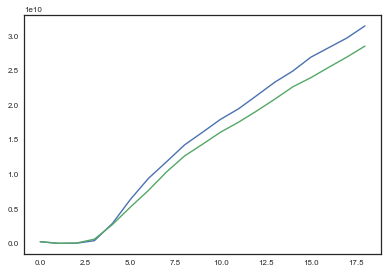

In [43]:
file = ('/data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun38.csv') 
dfcan = pd.read_csv(file)

HCW_bar = dfcan['HCW']
TrMass_bar = dfcan['TrMassHCW']
       
Phi_bar_mod = np.mean(np.array([(HCW_bar[ii]-HCW_bar[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))

Phi_Tr_bar = np.mean(np.array([(TrMass_bar[ii]-TrMass_bar[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))

plt.plot(HCW)
plt.plot(HCW_bar)


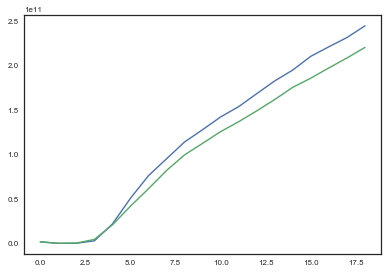

In [44]:
plt.plot(TrMass)
plt.plot(TrMass_bar)

In [45]:
print(Phi_bar_mod, Phi_Tr_bar)
print(Phi_mod, Phi_Tr)

38476.0463491 276314.623544
41463.8819239 299663.391529


In [15]:
(U*W*Hs)

1155808.864

In [16]:
U*W*Dh(f=9.66E-5, L=12800, N=5.5E-3 )

1734597.0920727274

In [17]:
Dh(f,L,Neff)

62.539677857024088

In [18]:
Dh(f,L,N)

168.6109090909091

In [81]:
Dh(f,L,0.012)

103.04